<a href="https://colab.research.google.com/github/tanaha2002/tkmt/blob/tai_lieu_hoc/XayDungModelDonGianVaGiaiThich.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import load_img
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from google.colab import drive

In [ ]:
# mount data từ cloud storage của mình
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/MLData'

/content/drive/My Drive/MLData


# Tổng quan bài toán:
#**Xây dựng model**:
Vì input của model là ảnh nên nghĩ đa phần sẽ nghĩ đến convolutional neural network (CNN) hay còn gọi là mạng nơ ron tích chập.

Mô hình chung bài toán CNN: Input image -> Convolutional layer (Conv) + Pooling layer (Pool) -> Fully connected layer (FC) -> Output.

In [23]:
imgW,imgH = 244,244

In [24]:
#load data
train_data = 'v_data/train'
valid_data = 'v_data/test'
total_train_sample = 400
total_valid_sample = 100
#số lần lặp khi train
epochs = 10
batch_size = 16

In [25]:
# if K.image_data_format() =='channels_first':
#   print(K.image_data_format())
#   input_shape = (3,imgW,imgH)
# else:
#   print(K.image_data_format())
#   input_shape = (imgW,imgH,3)

In [26]:
# backend đang chạy trên google colab là tensorflow (channel_last) nên định dạng cho image là (rows, cols, channels)
#còn nếu backend là theano thì định dạng là (channels, rows, cols)
input_shape = (imgW,imgH,3)
#channels của chúng ta là ảnh có màu nên sẽ là 3, nếu chúng ta train bằng ảnh xám thì channels nên được đổi thành 1

In [27]:
from keras.layers.convolutional import activations
#1.5
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=input_shape))
model.add(Activation('relu'))
#1.6
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#1.7
model.add(Flatten())
#1.8
model.add(Dense(64))
model.add(Activation('relu'))
#1.9
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 1.5 mô tả lớp Convolutionnal
- Tạo một API mô hình tuần tự (Sequential) và thêm từng lớp vào mô hình theo cách tuyến tính, từ đầu vào đến đầu ra.
- Tạo Convolutionnal Layers : Conv2D là convolution dùng để lấy các đặc trưng từ ảnh với các tham số : 
  - Với bài toán trên thì số filter sử dụng là 32, tức là mỗi tấm ảnh sẽ được áp 32 bộ lọc khi đi qua layer này. Ban đầu bộ lọc sẽ là những con số ngẫu nhiên, nhưng qua dần quá trình train, mô hình sẽ tự động dựa vào kết quả đầu ra với tập dữ liệu  để điều chỉnh bộ lọc sao cho phù hợp với từng tấm ảnh đầu vào.
  - ở tham số input_shape sẽ nhận dữ liệu đầu vào, tại đây ta định nghĩa kích thước đầu vào theo input_shape ta đã khai báo ở trên
  - tuple (2,2) là đầu vào cho tham số kernel_size, tức là xét mỗi filter (2 x 2) trượt trên hình gốc (244 x 244 x 3)
  - Và activation là hàm kích hoạt của layer. Đối với mỗi bài toán ta sử dụng các hàm activation khác nhau sao cho phù hợp.
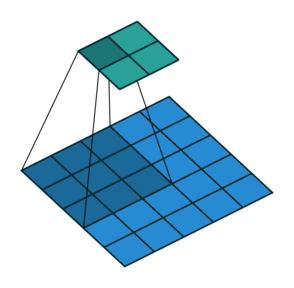

# 1.6 Lớp tổng hợp cực đại MaxPooling
- Lớp này được dùng để nén tấm ảnh lại sau khi qua các bộ lọc để các nét đặc trưng được biểu hiển rõ hơn.
  - Chúng ta chỉ định kích thước cho lớp tổng hợp là (2,2) tức là giảm kích thước của hình ảnh theo hệ số 4. Tạo ra một mảng pixel 2x2 và chọn giá trị pixel lớn nhất, biến 4 pixel thành 1 và lặp lại cho đến hết ảnh.
  **Mô tả:**
  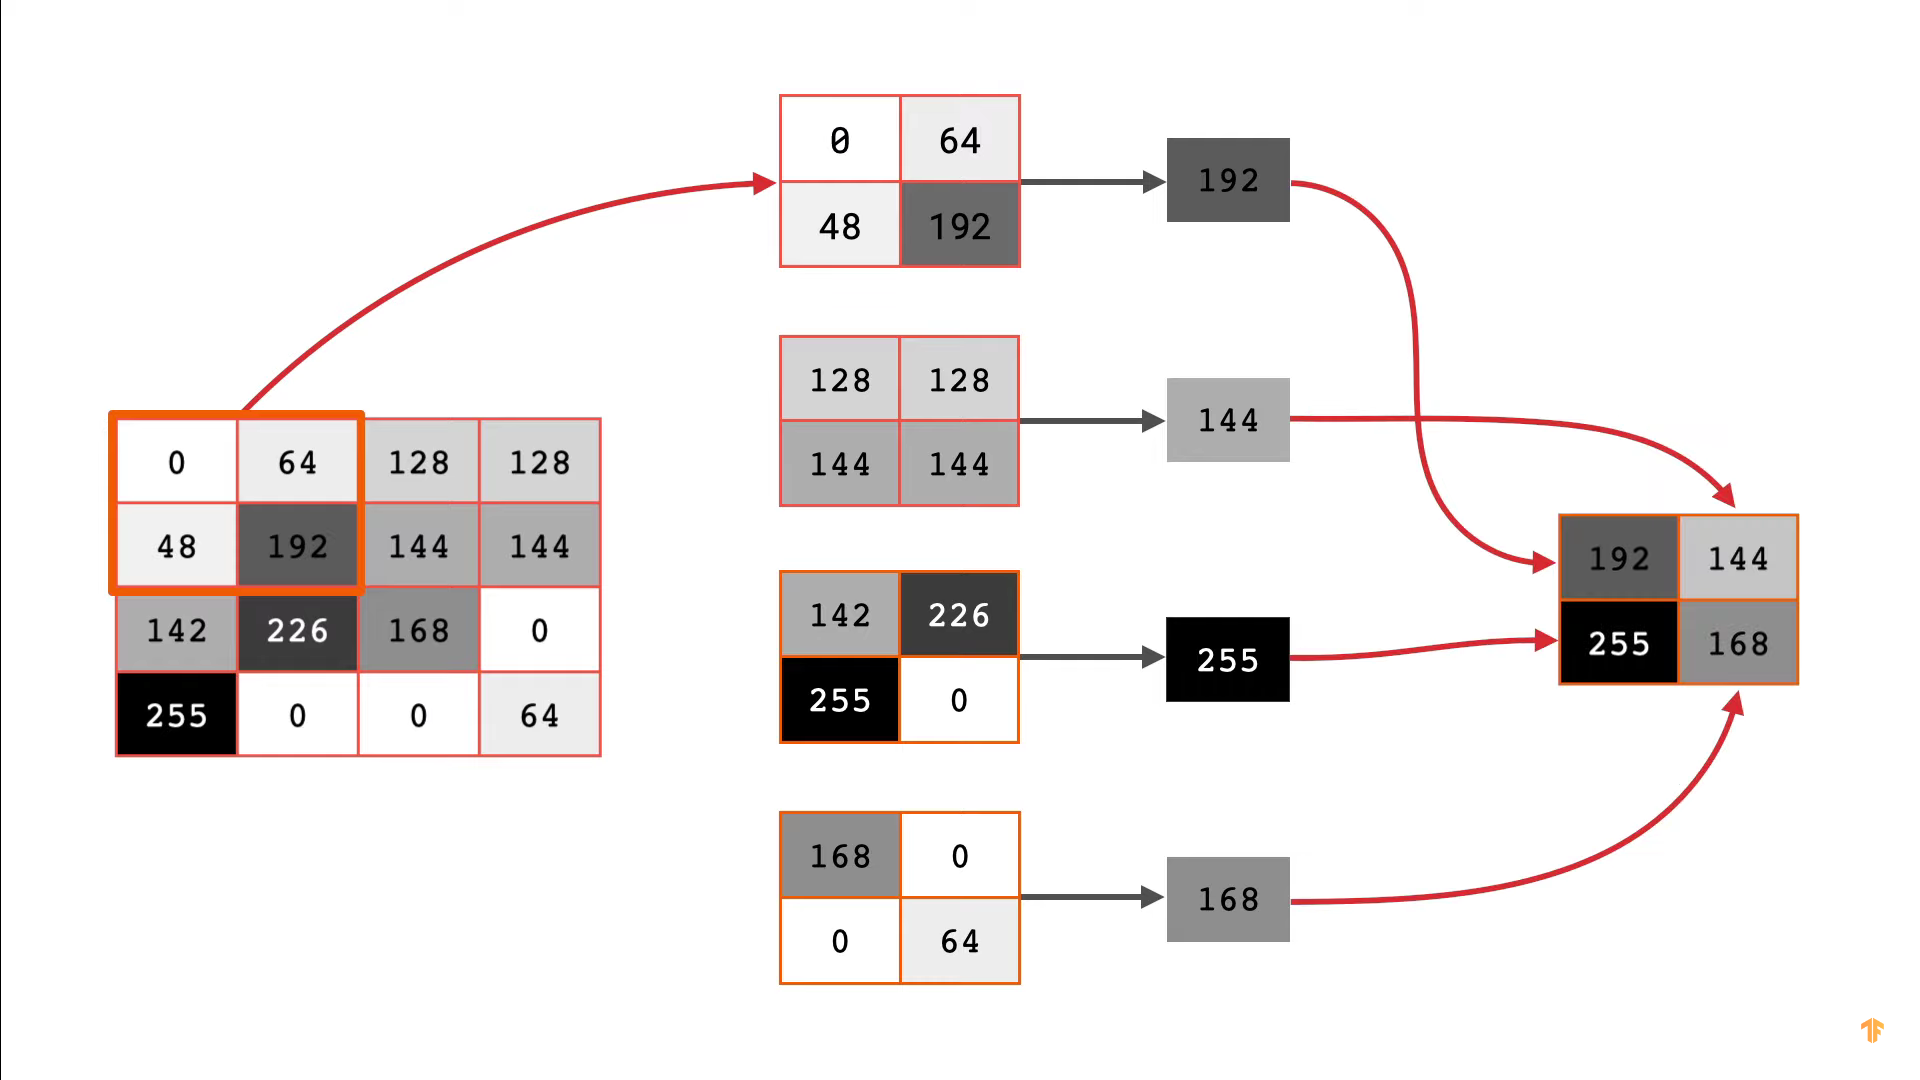


# 1.7 
- Lớp Flatten() để làm phẳng dữ liệu ma trận (n,n) chiều từ ảnh về thành 1 vector tuyến tính 1 chiều để dữ liệu đầu vào tốt cho mô hình hơn là ma trận (n,n) chiều.
  - Mô tả flatten:
  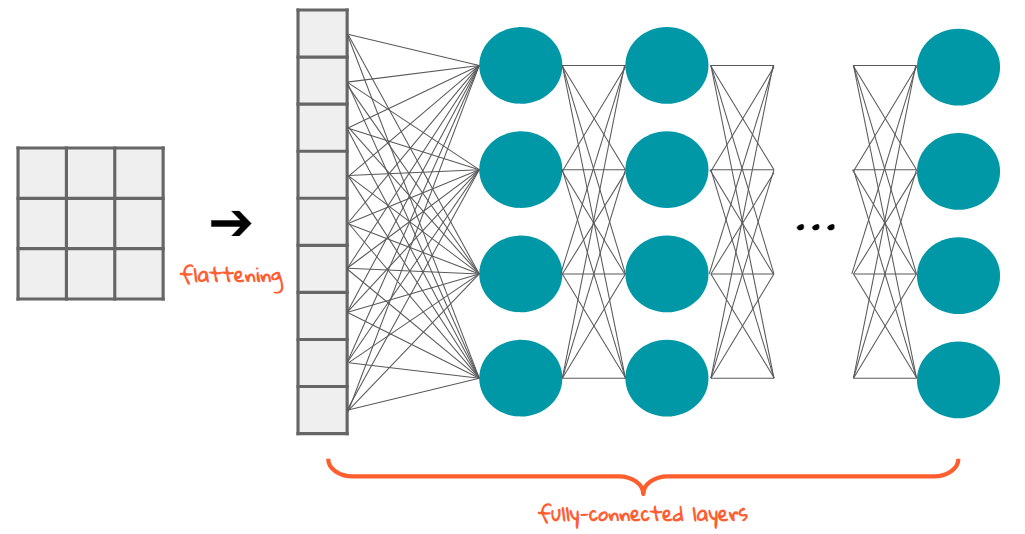

# 1.8 Dense
- Dense (): Layer này cũng như một layer neural network bình thường, với các tham số sau: output_dim là số đầu ra của nơ ron này.
- Ta có thể đặt các nơ ron liên tiếp nhau như trên phần Convolutionnal để quá trình train diễn ra được chính xác hơn.

# 1.9 Output layer
- Nơron cuối cùng ta sử dụng activation là sigmoid chứ không phải relu hay sofmax vì ở đây là bài toán phân loại của ta chỉ có 2 lớp là máy bay và xe, nếu bài toán phân loại của ta có đầu ra nhiều hơn 2 lớp ví dụ như bài toán nhận diện chữ viết thì ta nên thay sigmoid thành sofmax.

In [28]:
#Hàm compile là hàm chúng ta cần để xác định các optimizer trong quá trình train.
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [35]:
#Xử lý dữ liệu hình ảnh để chuyển đổi thành ma trận
train_datagen = ImageDataGenerator( # tạo thêm data bằng cách scale, rotation ,...để thêm data train
    rescale=1. / 255, #rescale để chuẩn hóa dữ liệu (pixel ảnh có giá trị từ 0 tới 255, ta chuẩn hóa ma trận gồm các giá trị chạy trong khoảng này về ma trận 0-1 sẽ hiệu quả hơn cho quá trình train)
    shear_range=0.2, # làm méo ảnh
    zoom_range=0.2, #zoom ngãu nhiên 0.2
    horizontal_flip=True) # lật ảnh ngẫu nhiên #mục đích của những hàm shear,zoom,flip là dùng để tạo ra sự tăng cường dữ liệu từ 1 tập dữ liệu nhỏ

test_datagen = ImageDataGenerator(rescale=1. / 255)
  
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(imgW, imgH), #size của ảnh đầu vào
    batch_size=batch_size, #gom lô 
    class_mode='binary') # ở đây ta chỉ phân loại 2 lớp là máy bay hoặc xe cũng có nghĩa là 0 hoặc 1 nên ta sử dụng class_mode là nhị phân
#ví dụ vì sao cần batch_size
#Giả sử ta có tập huấn luyện gồm 55.000 hình ảnh chọn batch-size là 55 images có nghĩa là mỗi lần cập nhật trọng số, ta dùng 55 images. 
#Lúc đó ta mất 55.000/55 = 1000 iterations (số lần lặp) để duyệt qua hết tập huấn luyện (hoàn thành 1 epochs). Có nghĩa là khi dữ liệu quá lớn, 
#chúng ta không thể đưa cả tập data vào train được, ta phải chia nhỏ data ra thành nhiều batch nhỏ hơn.
validation_generator = test_datagen.flow_from_directory(
    valid_data,
    target_size=(imgW, imgH),
    batch_size=batch_size,
    class_mode='binary')
  
history = model.fit(train_generator, #tập dữ liệu train
                    steps_per_epoch=total_train_sample // batch_size, #số lượng batch cần để hoàn thành 1 vòng train (epochs), ta có 400 mẫu, batch_size 16 vậy cần lặp 25 lần để xong 1 epochs
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=total_valid_sample // batch_size) #như trên


Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 6s 253ms/step - loss: 0.1692 - accuracy: 0.9525 - val_loss: 0.9222 - val_accuracy: 0.8125
Epoch 2/10
25/25 [==============================] - 6s 246ms/step - loss: 0.1696 - accuracy: 0.9350 - val_loss: 0.3472 - val_accuracy: 0.8750
Epoch 3/10
25/25 [==============================] - 8s 335ms/step - loss: 0.1330 - accuracy: 0.9650 - val_loss: 0.7640 - val_accuracy: 0.7708
Epoch 4/10
25/25 [==============================] - 6s 245ms/step - loss: 0.1284 - accuracy: 0.9550 - val_loss: 0.3096 - val_accuracy: 0.8958
Epoch 5/10
25/25 [==============================] - 6s 245ms/step - loss: 0.0689 - accuracy: 0.9775 - val_loss: 0.3951 - val_accuracy: 0.8958
Epoch 6/10
25/25 [==============================] - 6s 251ms/step - loss: 0.1236 - accuracy: 0.9475 - val_loss: 0.3323 - val_accuracy: 0.8854
Epoch 7/10
25/25 [==============================] - 6s 251ms/step 

[0.44876834750175476, 0.8600000143051147]


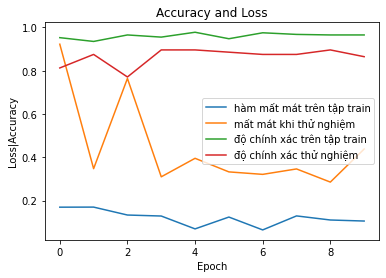

In [41]:
#Vẽ đồ thị để quan sát tổng quan các giá trị trong quá trình train
fig = plt.figure()
plt.plot(np.arange(0, epochs), model.history.history['loss'], label='hàm mất mát trên tập train')
plt.plot(np.arange(0, epochs), model.history.history['val_loss'], label='mất mát khi thử nghiệm')
plt.plot(np.arange(0, epochs), model.history.history['accuracy'], label='độ chính xác trên tập train')
plt.plot(np.arange(0, epochs), model.history.history['val_accuracy'], label='độ chính xác thử nghiệm')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()
score = model.evaluate(validation_generator,verbose=0)
print(score)

In [42]:
#lưu mô hình sau khi train
model.save('model_saved.h5')

In [43]:
from keras.models import load_model


Predicted Class (0 - Cars , 1- Planes):  0.008217617


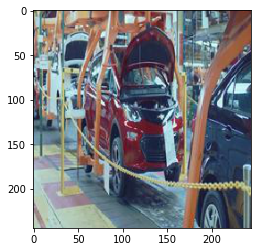

In [51]:
from keras.models import load_model

model = load_model('model_saved.h5')
x = np.random.randint(1,50)
types =  "planes" if np.random.randint(0,1) == 1 else "cars"
image = load_img('v_data/test/'+types+'/'+str(x)+'.jpg', target_size=(244, 244))
plt.imshow(image)
img = np.array(image)
img = img / 255.0 #chuẩn hóa 
img = img.reshape(1,244,244,3)

label = model.predict(img)
print("Predicted Class (0 - Cars , 1- Planes): ", label[0][0])